In [17]:
import numpy as np
import math
from numpy import random
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [18]:
class Layer:
    def forward(self,x):
        raise NotImplementedError()
    def backward(self, out_grad, learning_rate):
        raise NotImplementedError()
    def __call__(self, *args):
        return self.forward(*args)

In [19]:
class Linear(Layer):
    def __init__(self, in_size, out_size, enable_bias=True) -> None:
        '''
        in_size: the number of datapoints in the input, i.e. the input size
        out_size: the number of neurons in the layer, i.e. the output size
        enable_bias: whether to include bias in the layer
        '''
        # intialize weights and bias
        self.initialize_parameters(in_size, out_size, enable_bias)

    def initialize_parameters(self, in_size, out_size, enable_bias):
        '''
        reinitialize the weights and bias
        '''
        #self.weights = kaiming_uniform(out_size, in_size)
        #self.bias = kaiming_uniform(out_size, 1) if enable_bias is not None else None
        self.weights = np.random.randn(out_size, in_size) * np.sqrt(2/in_size)
        self.bias = np.random.randn(out_size, 1) * np.sqrt(2/in_size) if enable_bias is not None else None

    def forward(self, input):
        '''
        input: input to the layer
        return: linear transformation of the input, WX + B
        '''
        self.input = input
        return  (self.weights @ input) + (self.bias if self.bias is not None else 0)
    
    def backward(self, out_grad, learning_rate):
        '''
        out_grad: gradient of the loss w.r.t the output of the layer
        learning_rate: learning rate for updating the weights
        return: gradient of the loss w.r.t the input of the layer so that it can be used as input to the previous layer to ues in updating its parameters 
        '''
        new_outgrad = self.weights.T @ out_grad     # gradient of the loss w.r.t the input of the layer
        
        w_grad = out_grad @ self.input.T            # gradient of the loss w.r.t the weights
        self.weights -= learning_rate * w_grad      # update the weights

        if (self.bias is not None):
            b_grad = np.mean(out_grad, axis=1).reshape(-1,1)    # gradient of the loss w.r.t the bias
                                                                # mean to equalize the broadcasting
                                                                # reshape from (n,) to (n,1) to make it compatible with the bias shape
            self.bias -= learning_rate * b_grad              # update the bias        

        return new_outgrad

In [20]:
class ReLU(Layer):
    def __init__(self) -> None:
        None
    def forward(self, x):
        '''
        x: the input of the RelU layer
        return: RelU(x)
        '''
        self.x = x
        return np.where(x > 0, x, 0)
        # return np.maximum(x, 0)
    
    def backward(self, out_grad, learning_rate):
        '''
        out_grad: the output gradient of the previous layer
        return: RelU'(x) ⊙ outgrad
        '''
        Relu_prime = np.where(self.x > 0, 1, 0)     # derivative of the Relu function
        #Relu_prime = (self.x > 0).astype(int)

        return np.multiply(Relu_prime, out_grad)    # element-wise multiplication of the derivative of the Relu function and the output gradient of the previous layer

In [21]:
class MSE:
    def __init__(self) -> None:
        None
    def loss(self, y_predict, y):
        '''
        y_predict: the predicted value
        y: the actual value (target): must be one hot encoded
        return: the mean squared error loss
        '''
        return np.mean((y_predict - y)**2)
    
    def loss_gradient(self, y_predict, y):
        '''
        y_predict: the predicted value
        y: the actual value (target)
        return: the gradient of the loss w.r.t the predicted value
        '''
        no_of_classes = y.shape[0]          # y is transposed
        no_of_datapoints = y.shape[1]
        return (2/ (no_of_classes * no_of_datapoints)) * (y_predict - y) 

In [22]:
class CategoricalCrossEntropyLoss:
    def __init__(self) -> None:
        pass
    
    def loss(self, y_predict, y):
        '''
        y_predict: the predicted value (raw scores/logits)
        y: the actual value (target): must be one hot encoded
        return: the categorical cross-entropy loss
        '''
        # Avoid division by zero
        epsilon = 1e-15
        # Clip values to avoid log(0)
        y_predict = np.clip(y_predict, epsilon, 1 - epsilon)
        return -np.sum(y * np.log(y_predict)) / y.shape[1]  # Divide by number of samples for mean
    
    def loss_gradient(self, y_predict, y):
        '''
        y_predict: the predicted value (raw scores/logits)
        y: the actual value (target)
        return: the gradient of the loss w.r.t the predicted value
        '''
        return (y_predict - y) / y.shape[1]


In [23]:
class NN:
    def __init__(self, x, y, layers_dim, learning_rate, max_iterations, activation_layer, loss, enable_bias=True) -> None:
        '''
        x: the input data
        y: the target data
        layers_dim: the dimensions of the layers of the neural network
        learning_rate: the learning rate of the neural network
        max_iterations: the maximum number of iterations to train the neural network
        activation_function: the activation function of the neural network
        error: the error function of the neural network
        '''
        self.x = x.T
        self.y = y.T
        self.loss = loss
        self.learning_rate = learning_rate
        self.max_iterations = max_iterations
        self.network = []
        self.initialize_network(layers_dim, activation_layer, enable_bias)
    
    def initialize_network(self, layers_dim, activation_layer, enable_bias) -> None:
        '''
        initialize the layers of the neural network
        '''
        # check for the dimensions of the input and output layers
        assert layers_dim[0] == self.x.shape[0], f"The input layer dimension does not match the input data, it should be {self.x.shape[0]}"
        assert layers_dim[-1] == self.y.shape[0], f"The output layer dimension does not match the target data, it should be {self.y.shape[0]}"
        
        for i in range(len(layers_dim) - 1):
            self.network.append(Linear(layers_dim[i], layers_dim[i+1], enable_bias))
            self.network.append(activation_layer())

    def forward(self):
        output = self.x   # input to the first layer
        for layer in self.network:
            output = layer(output)      # the output of the previous layer is the input to the next layer
            
        return output   # the output of the last layer
    
    def backward(self, y_predict):
        out_grad = self.loss.loss_gradient(self, y_predict, self.y)    # gradient of the loss w.r.t the output of the last layer
        for layer in reversed(self.network):
            out_grad = layer.backward(out_grad, self.learning_rate)    # gradient of the loss w.r.t the input of the layer
        return out_grad

    def train(self):
        for epoch in range(self.max_iterations):
            y_predict = self.forward()    # the output of the last layer
            loss = self.loss.loss(self, y_predict, self.y)
            accuracy = calculate_accuracy(y_predict, self.y)
            self.backward(y_predict)
            print(f"Epoch: {epoch + 1}, Loss: {loss:.2f}, accuracy: {accuracy*100:.2f}%")

    def predict(self, x):
        output = x
        for layer in self.network:
            output = layer(output)
        return output

In [24]:
def calculate_accuracy(predictions, true_labels):
    '''
    predictions: the predicted labels
    true_labels: the actual labels
    return: the accuracy of the model
    '''
    pred_labels = np.argmax(predictions, axis=0)
    true_labels = np.argmax(true_labels, axis=0)
    accuracy = np.mean(pred_labels == true_labels)
    return accuracy

In [25]:
def kaiming_uniform(fan_in, fan_out, **kwargs):
    bound = math.sqrt(2) * math.sqrt(3/fan_in)
    u = random.uniform(-bound, bound,fan_in*fan_out) 
    return np.reshape(u,(fan_in,fan_out))

## Fashion MNIST

In [26]:
from tensorflow.keras.datasets import fashion_mnist

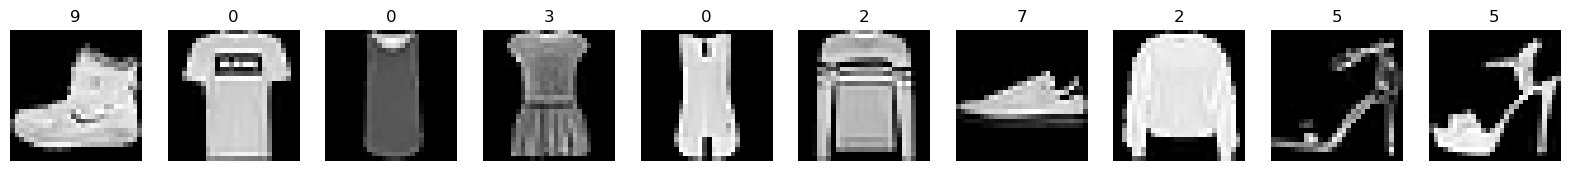

In [27]:
fashion_mnist = fashion_mnist.load_data()       # load the fashion mnist dataset

# plot the 10 classes of the fashion mnist dataset
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 10, figsize=(20, 20))
for i in range(10):
    ax[i].imshow(fashion_mnist[0][0][i], cmap='gray')
    ax[i].set_title(fashion_mnist[0][1][i])
    ax[i].axis('off')
plt.show()

In [38]:
X = fashion_mnist[0][0].reshape(60000, 784) / 255
y = fashion_mnist[0][1]
y_one_hot = np.eye(10)[y]                       # one hot encode the target labels

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized = X_train_normalized
X_test_normalized = X_test_normalized.T
y_train = y_train
y_test = y_test.T

layers_dim = [784,128,10]
alpha = 0.2   # Learning rate
activation_layer = ReLU
loss = MSE
enable_bias = True

nn = NN(X_train_normalized, y_train, layers_dim, alpha, 1000, activation_layer, loss, enable_bias)
nn.train()
y_pred = nn.predict(X_test_normalized)

accuracy = calculate_accuracy(y_pred, y_test)
print("==========================================")
print(f"Test data Accuracy: {accuracy * 100:.2f}%")

Epoch: 1, Loss: 0.75, accuracy: 5.34%
Epoch: 2, Loss: 0.20, accuracy: 12.67%
Epoch: 3, Loss: 0.11, accuracy: 11.41%
Epoch: 4, Loss: 0.11, accuracy: 13.01%
Epoch: 5, Loss: 0.11, accuracy: 14.74%
Epoch: 6, Loss: 0.10, accuracy: 16.37%
Epoch: 7, Loss: 0.10, accuracy: 17.66%
Epoch: 8, Loss: 0.10, accuracy: 18.58%
Epoch: 9, Loss: 0.10, accuracy: 19.42%
Epoch: 10, Loss: 0.10, accuracy: 20.35%
Epoch: 11, Loss: 0.10, accuracy: 21.23%
Epoch: 12, Loss: 0.10, accuracy: 22.12%
Epoch: 13, Loss: 0.09, accuracy: 22.93%
Epoch: 14, Loss: 0.09, accuracy: 23.72%
Epoch: 15, Loss: 0.09, accuracy: 24.48%
Epoch: 16, Loss: 0.09, accuracy: 25.12%
Epoch: 17, Loss: 0.09, accuracy: 25.76%
Epoch: 18, Loss: 0.09, accuracy: 26.42%
Epoch: 19, Loss: 0.09, accuracy: 27.08%
Epoch: 20, Loss: 0.09, accuracy: 27.70%
Epoch: 21, Loss: 0.09, accuracy: 28.36%
Epoch: 22, Loss: 0.09, accuracy: 29.03%
Epoch: 23, Loss: 0.09, accuracy: 29.65%
Epoch: 24, Loss: 0.09, accuracy: 30.37%
Epoch: 25, Loss: 0.09, accuracy: 31.09%
Epoch: 26,

## MNIST Dataset

In [36]:
from tensorflow.keras.datasets import mnist
mnist_dataset = mnist.load_data()

X = mnist_dataset[0][0].reshape(60000, 784) / 255
y = mnist_dataset[0][1]
y_one_hot = np.eye(10)[y]                       # one hot encode the target labels

# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train_normalized = scaler.fit_transform(X_train)
X_test_normalized = scaler.transform(X_test)

X_train_normalized = X_train_normalized
X_test_normalized = X_test_normalized.T
y_train = y_train
y_test = y_test.T

layers_dim = [784,64,10]
lr = 0.2   # Learning rate
activation_layer = ReLU
loss = MSE
enable_bias = True

nn = NN(X_train_normalized, y_train, layers_dim, lr, 1000, activation_layer, loss, enable_bias)
nn.train()
y_pred = nn.predict(X_test_normalized)

# Calculate the accuracy of the model with the test data
accuracy = calculate_accuracy(y_pred, y_test)
print("==========================================")
print(f"Test data Accuracy: {accuracy * 100:.2f}%")

Epoch: 1, Loss: 1.09, accuracy: 7.47%
Epoch: 2, Loss: 0.35, accuracy: 11.92%
Epoch: 3, Loss: 0.24, accuracy: 14.90%
Epoch: 4, Loss: 0.19, accuracy: 17.29%
Epoch: 5, Loss: 0.16, accuracy: 19.21%
Epoch: 6, Loss: 0.14, accuracy: 20.69%
Epoch: 7, Loss: 0.13, accuracy: 21.83%
Epoch: 8, Loss: 0.12, accuracy: 22.80%
Epoch: 9, Loss: 0.12, accuracy: 23.77%
Epoch: 10, Loss: 0.11, accuracy: 24.66%
Epoch: 11, Loss: 0.11, accuracy: 25.49%
Epoch: 12, Loss: 0.10, accuracy: 26.27%
Epoch: 13, Loss: 0.10, accuracy: 27.11%
Epoch: 14, Loss: 0.10, accuracy: 27.90%
Epoch: 15, Loss: 0.10, accuracy: 28.70%
Epoch: 16, Loss: 0.10, accuracy: 29.48%
Epoch: 17, Loss: 0.09, accuracy: 30.28%
Epoch: 18, Loss: 0.09, accuracy: 31.01%
Epoch: 19, Loss: 0.09, accuracy: 31.79%
Epoch: 20, Loss: 0.09, accuracy: 32.50%
Epoch: 21, Loss: 0.09, accuracy: 33.27%
Epoch: 22, Loss: 0.09, accuracy: 34.03%
Epoch: 23, Loss: 0.09, accuracy: 34.81%
Epoch: 24, Loss: 0.09, accuracy: 35.59%
Epoch: 25, Loss: 0.09, accuracy: 36.39%
Epoch: 26,